In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./input"))

# Any results you write to the current directory are saved as output.

['train.zip', 'train.csv', 'test.zip', 'test', 'train', 'sample_submission.csv', '.ipynb_checkpoints']


In [38]:
# Import the training data
train = pd.read_csv("./input/train.csv")
print(train.head())

                                     Id   Target
0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0
2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5
3  000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1
4  001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18


In [39]:
# Map of the targets
subcell_locs = {
    0:  "Nucleoplasm", 
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center" ,  
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",
    8:  "Peroxisomes",
    9:  "Endosomes",
    10:  "Lysosomes",
    11:  "Intermediate filaments",   
    12:  "Actin filaments",
    13:  "Focal adhesion sites",   
    14:  "Microtubules",
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",
    18:  "Microtubule organizing center",  
    19:  "Centrosome",
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions", 
    23:  "Mitochondria",
    24:  "Aggresome",
    25:  "Cytosol",
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings" 
}

### Exploratory Data Analysis

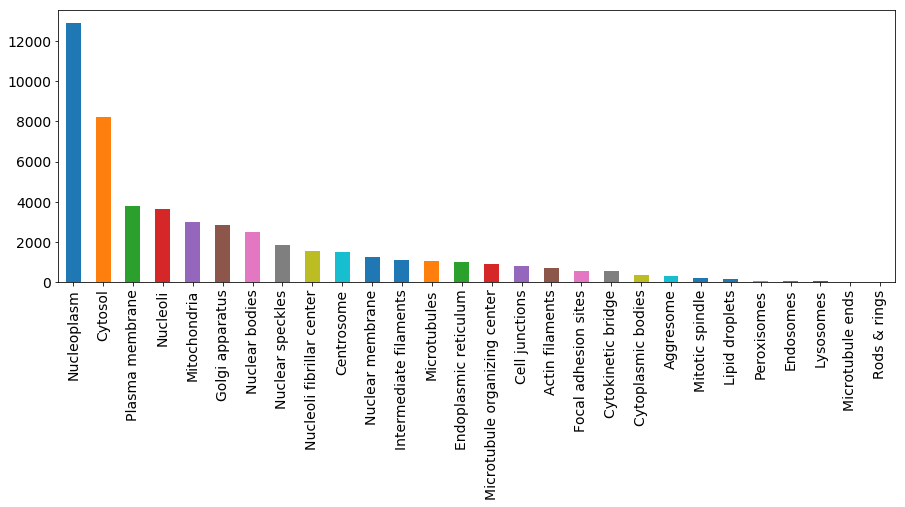

In [40]:
# Target distribution
labels_num = [value.split() for value in train['Target']]
labels_num_flat = list(map(int, [item for sublist in labels_num for item in sublist]))
labels = ["" for _ in range(len(labels_num_flat))]
for i in range(len(labels_num_flat)):
    labels[i] = subcell_locs[labels_num_flat[i]]

fig, ax = plt.subplots(figsize=(15, 5))
pd.Series(labels).value_counts().plot('bar', fontsize=14)

In [41]:
path_to_train = './input/train/'

def load_image(file):
    image_red_ch = cv2.imread(path_to_train + file +'_red.png', cv2.IMREAD_GRAYSCALE).astype(np.float32)/255
    image_yellow_ch = cv2.imread(path_to_train + file +'_yellow.png', cv2.IMREAD_GRAYSCALE).astype(np.float32)/255
    image_green_ch = cv2.imread(path_to_train + file +'_green.png', cv2.IMREAD_GRAYSCALE).astype(np.float32)/255
    image_blue_ch = cv2.imread(path_to_train + file +'_blue.png', cv2.IMREAD_GRAYSCALE).astype(np.float32)/255
    
    # Stack the channels
    image = np.stack((image_red_ch, image_green_ch, image_blue_ch, image_yellow_ch), axis=-1)
    
    # Return the image stacked
    return image

def get_color_channels():
    green_ch = {'red':   ((0.0,  0.0, 0.0),
                   (1.0,  0.0, 0.0)),

         'green': ((0.0,  0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0,  1.0, 1.0)),

         'blue':  ((0.0,  0.0, 0.0),
                   (1.0,  0.0, 0.0))}

    red_ch = {'red':   ((0.0,  0.0, 0.0),
                       (0.75, 1.0, 1.0),
                       (1.0,  1.0, 1.0)),

             'green': ((0.0,  0.0, 0.0),
                       (1.0,  0.0, 0.0)),

             'blue':  ((0.0,  0.0, 0.0),
                       (1.0,  0.0, 0.0))}

    blue_ch = {'red':   ((0.0,  0.0, 0.0),
                       (1.0,  0.0, 0.0)),

             'green': ((0.0,  0.0, 0.0),
                       (1.0,  0.0, 0.0)),

             'blue':  ((0.0,  0.0, 0.0),
                       (0.75, 1.0, 1.0),
                       (1.0,  1.0, 1.0))}

    yellow_ch = {'red': ((0.0,  0.0, 0.0),
                       (0.75, 1.0, 1.0),
                       (1.0,  1.0, 1.0)),

             'green': ((0.0,  0.0, 0.0),
                       (0.75, 1.0, 1.0),
                       (1.0,  1.0, 1.0)),

             'blue':  ((0.0,  0.0, 0.0),
                       (1.0,  0.0, 0.0))}
    
    return (red_ch, green_ch, blue_ch, yellow_ch)

def display_channels(img):
    img_red, img_green, img_blue, img_yellow= img[:,:,0],img[:,:,1],img[:,:,2], img[:,:,3]
    red_ch, green_ch, blue_ch, yellow_ch = get_color_channels();
    
     # Register the color map with the plot
    plt.register_cmap(name='greens', data=green_ch)
    plt.register_cmap(name='reds', data=red_ch)
    plt.register_cmap(name='blues', data=blue_ch)
    plt.register_cmap(name='yellows', data=yellow_ch)
    
    fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(15, 15))
    ax[0, 0].imshow(img_green, cmap='greens')
    ax[0, 0].set_title("Protein of interest", fontsize=18)
    ax[0, 1].imshow(img_red, cmap='reds')
    ax[0, 1].set_title("Microtubules", fontsize=18)
    ax[1, 0].imshow(img_blue, cmap='blues')
    ax[1, 0].set_title("Nucleus", fontsize=18)
    ax[1, 1].imshow(img_yellow, cmap='yellows')
    ax[1, 1].set_title("Endoplasmic reticulum", fontsize=18)
    for i in range(2):
        for j in range(2):
            ax[i, j].set_xticklabels([])
            ax[i, j].set_yticklabels([])
            ax[i, j].tick_params(left=False, bottom=False)
    plt.show()
    
def display_image(img):
    plt.imshow((img[:,:,:3]*255).astype(np.int))

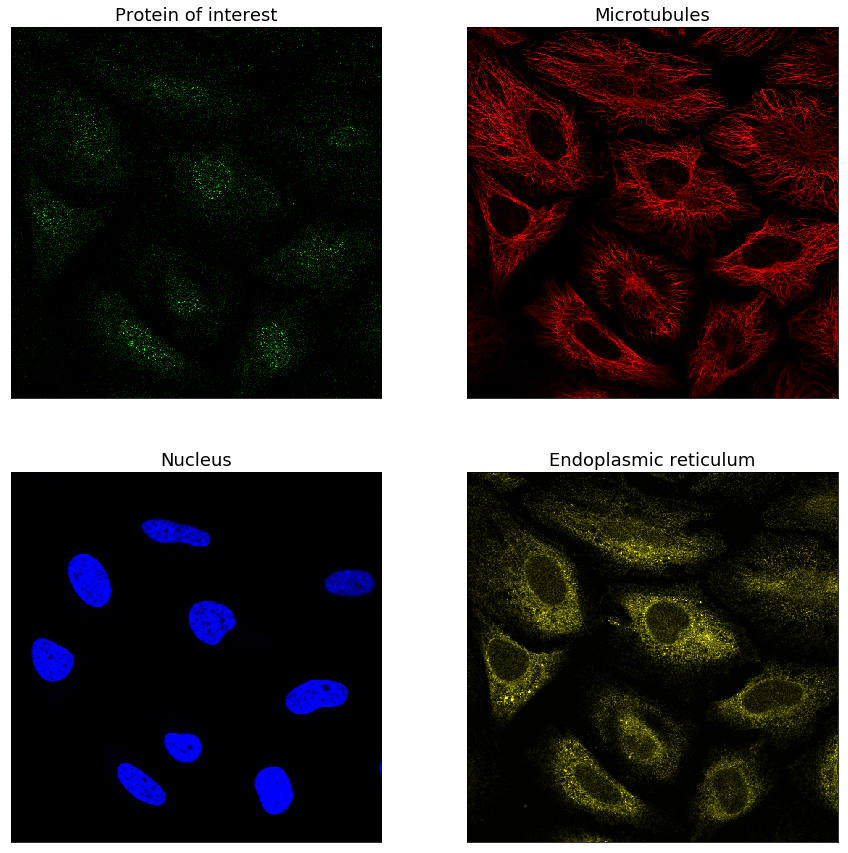

In [42]:
# Display color channels for an image in the training set. 
im_id = train.loc[567, "Id"]
img = load_image(im_id)
# green_ch, red_ch, blue_ch, yellow_ch = get_color_channels()

display_channels(img)

In [43]:
# Find the common number of classes for each training sample.
def count_target(target_val):
    return len(target_val.split(' '))

train['nclass'] = train.Target.map(count_target)
train.head()

,Id,Target,nclass
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0,2
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0,4
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,1
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18,1


In [44]:
count_labels = []
for i in range(train.nclass.min(), train.nclass.max() + 1):
    count_labels.append(np.sum(train.nclass==i))
    print('No. of images with',i,'label:',count_labels[-1])

No. of images with 1 label: 15126
No. of images with 2 label: 12485
No. of images with 3 label: 3160
No. of images with 4 label: 299
No. of images with 5 label: 2


In [45]:
# Visualizing the Training Data by Number of Classes
def visualize_by_class(nclass, image_count=2):
    count = 0
    for i in range(len(train)):
        if count == image_count:
            break;
            
        if(train.loc[i,'nclass'] == nclass):
            im_id = train.loc[i, "Id"]
            print('Image Id:', im_id)
            img = load_image(im_id)
            display_channels(img)
            count+=1

Image Id: 183d51d4-bbc5-11e8-b2bc-ac1f6b6435d0


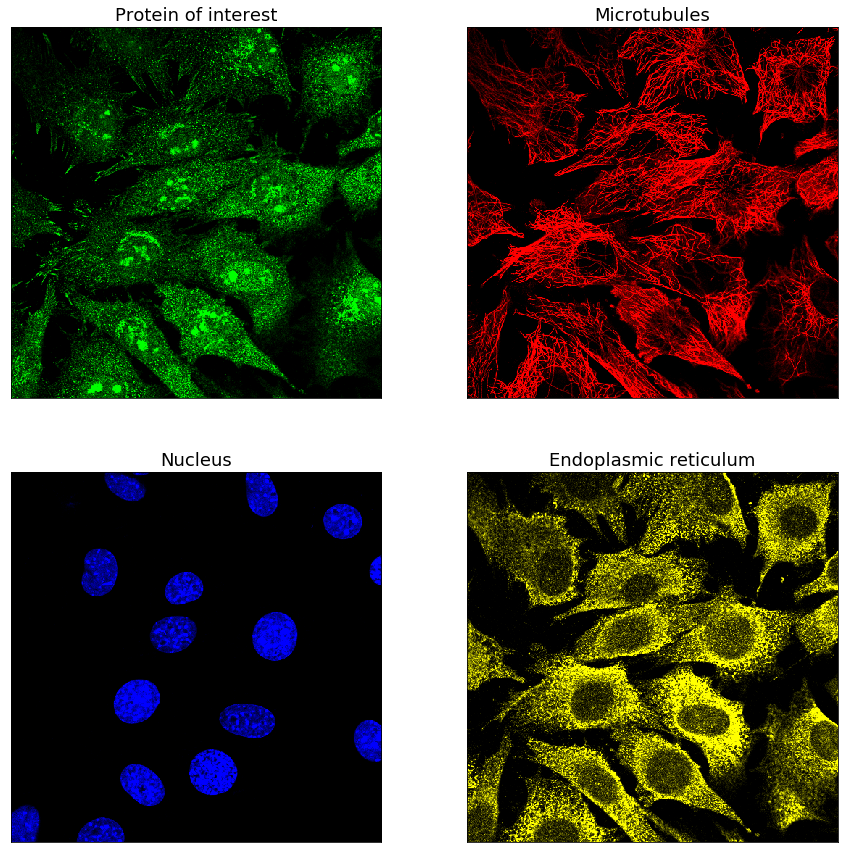

Image Id: dbc51f18-bbb8-11e8-b2ba-ac1f6b6435d0


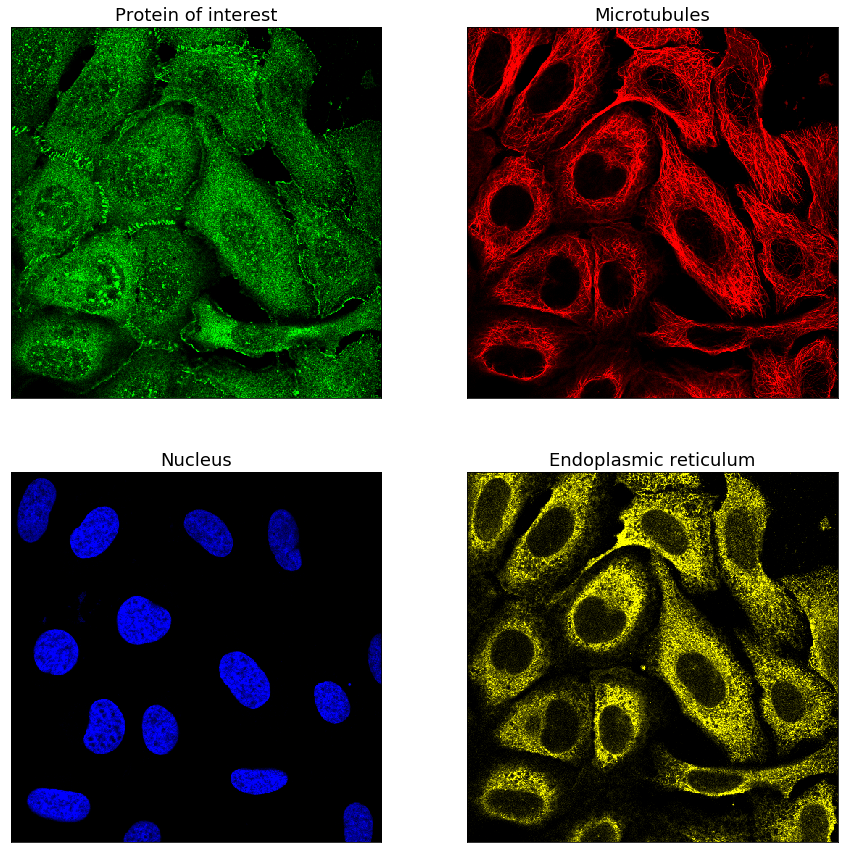

In [46]:
visualize_by_class(5)

In [47]:
def view_images_by_subcell(subcell_id, image_count = 2):
    count = 0
    for i in range(len(train)):
        if count == image_count:
            break;
            
        if(str(subcell_id) in train.loc[i, 'Target']):
            im_id = train.loc[i, "Id"]
            print('Image Id:', im_id)
            img = load_image(im_id)
            display_channels(img)
            count+=1

Image Id: 002ff91e-bbb8-11e8-b2ba-ac1f6b6435d0


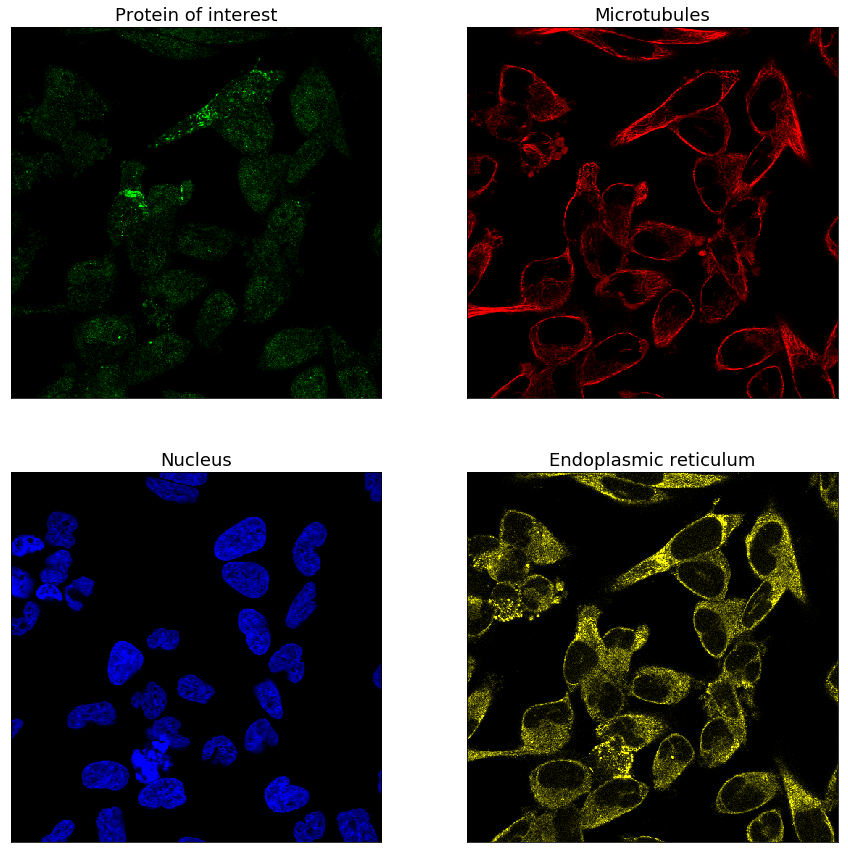

In [48]:
# View images with mitochondira 
view_images_by_subcell(subcell_id=23, image_count=1)